### 적용이 힘들어 보이는 것
1. 고개가 정자세가 아니라 기울어져 있을 때
2. 사진이 너무 밝거나 어두울 때
3. 마스크를 착용하는 사진일 때

### 의문점
1. cv2.addweighted함수를 노드에서 추천을 해주었는데, 두개를 투명하게 섞는 함수 말고, 이미지 스티커 하나만 투명도를 조절하는 함수가 있지 않을까?
2. img_bgr 을 이용을 계속 했는데 진작에 img_rgb로 변환후에 사용하는 것이 더 효과적이지 않을까
3. 왜 알리를 인식을 제대로 못하는걸까 ㅠㅠ

### 개선점
1. 눕히거나 각도가 틀어진 이미지를 수염도 각도에 맞추어 붙히기
2. 어두운 사진 밝은 사진에서 테스트 해보기
3. 수염을 기울였을때 좌우 비율을 맞추기

In [1224]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

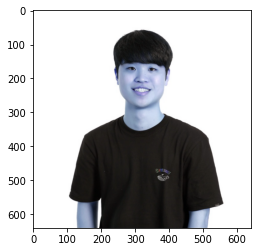

In [1225]:
my_image_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/images/profile.png'
img_bgr = cv2.resize(cv2.imread(my_image_path), (640, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

matplotlib, dlib 등의 이미지는 RGB 순으로 사용하는데, opencv는 예외적으로 BGR을 사용

그래서 원본 사진에서 붉은색->푸른색, 푸른색->붉은색

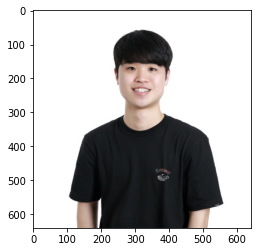

In [1226]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

색상을 올바르게 출력하고 싶다면 `cv2.cvtColor` 메소드를 사용하여 BGR2RGB 진행

In [1227]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print('인식한 얼굴 개수 :', len(dlib_rects))

인식한 얼굴 개수 : 1


num of img pyramid를 안주면 알아서 얼굴 개수를 detecting 해줌

detector_hog는 img pyramid개수를 반환하여 실제로 반복문을 돌려도 한번만 실행하는 것을 알 수 있음

\_\_len\_\_이 구현이 되어있기 때문에 len(dilb_rects_cp)로 개수 확인할 수 있음

rectangles[[(253, 139) (382, 268)]]


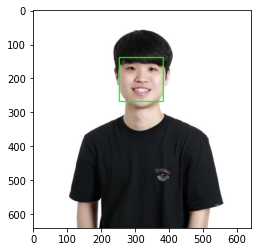

In [1228]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

모든 얼굴들을 순회하며 얼굴로 인식된 사각형을 그려줍니다.

In [1229]:
model_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [1230]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

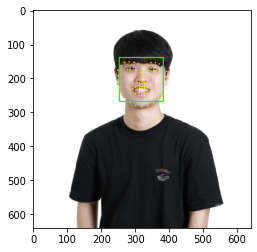

In [1231]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

landmark로 인식한 곳에 점을 찍어줍니다.

In [1232]:

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(320, 204)
(x,y) : (320,204)
(w,h) : (130,130)


x, y, w, h에 해당하는 각각의 좌표들을 찾아줍니다.

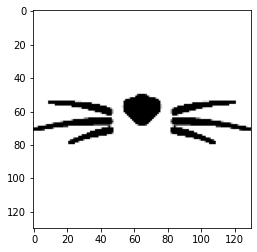

In [1233]:
sticker_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker)

스티커 사이즈를 얼굴 크기에 맞게 조정합니다.

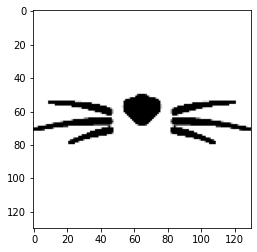

(130, 130, 3)


In [1234]:
plt.imshow(img_sticker)
plt.show()
print (img_sticker.shape)

In [1235]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (255,139)


In [1236]:
if refined_y < 0:
  img_sticker = img_sticker[-refined_y:]
  print (img_sticker.shape)
  refined_y = 0
  print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [1237]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

스티커 area만큼의 크기를 구한 이후, 이미지에 img_sticker를 삽입해줌

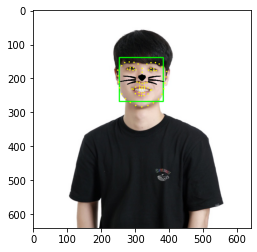

In [1238]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [1239]:
print(img_sticker.shape)

(130, 130, 3)


### 더 나아기기: 반투명한 고양이 수염 적용

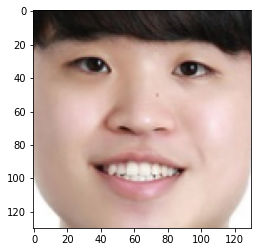

sticker_area


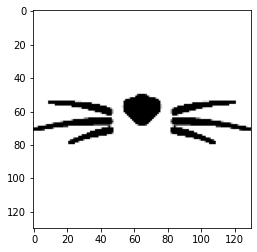

img_sticker


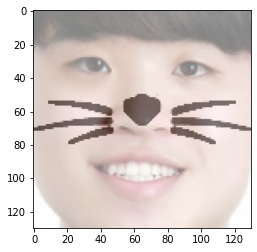

cv2.addWeighted() 적용


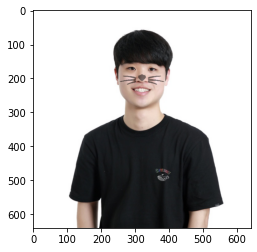

반투명한 고양이 수염 출력


In [1240]:
sticker_area = img_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
plt.imshow(sticker_area)
plt.show()
print('sticker_area')
plt.imshow(img_sticker)
plt.show()
print('img_sticker')
plt.imshow(cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.5, 0))
plt.show()
print('cv2.addWeighted() 적용')
weighted_sticker = cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.5, 0)
img_rgb[refined_y:+refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] =\
    np.where(img_sticker==255,sticker_area, weighted_sticker)
plt.imshow(img_rgb)
plt.show()
print('반투명한 고양이 수염 출력')

### 여러사람

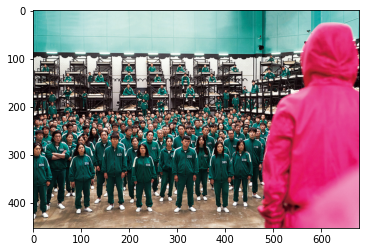

In [1250]:
my_image_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/images/group.png'
img_bgr = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_rgb.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_rgb)
plt.show()


In [1251]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print('인식한 얼굴 개수 :', len(dlib_rects))

인식한 얼굴 개수 : 0


사람의 얼굴의 크기가 너무 작아서 인식이 되지 않음

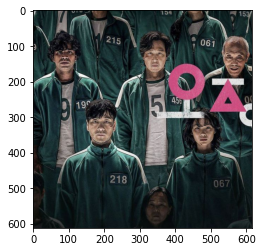

In [1252]:
my_image_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/images/group2.png'
img_bgr = cv2.imread(my_image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_rgb.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_rgb)
plt.show()


In [1253]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print('인식한 얼굴 개수 :', len(dlib_rects))

인식한 얼굴 개수 : 5


rectangles[[(154, 296) (229, 370)], [(536, 122) (598, 184)], [(312, 528) (386, 602)], [(303, 105) (378, 179)], [(446, 322) (508, 384)]]


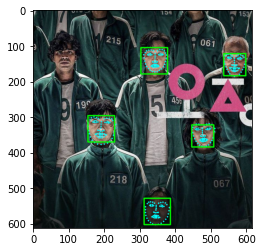

In [1261]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_show)
plt.show()

모든 얼굴들을 순회하며 얼굴로 인식된 사각형을 그려줍니다.

In [1262]:
import os
model_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [1263]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

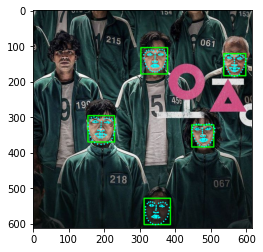

In [1264]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

plt.imshow(img_show)
plt.show()

landmark로 인식한 곳에 점을 찍어줍니다.

In [1283]:
x_list = []
y_list = []
w_list = []
h_list = []

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x_list.append(landmark[30][0])
    y_list.append(landmark[30][1])
    w_list.append(dlib_rect.width())
    h_list.append(dlib_rect.height())
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(190, 332)
(x,y) : (476,348)
(w,h) : (63,63)
(566, 153)
(x,y) : (476,348)
(w,h) : (63,63)
(345, 561)
(x,y) : (476,348)
(w,h) : (63,63)
(343, 141)
(x,y) : (476,348)
(w,h) : (63,63)
(476, 348)
(x,y) : (476,348)
(w,h) : (63,63)


x, y, w, h에 해당하는 각각의 좌표들을 찾아줍니다.

In [1292]:
sticker_path = os.getenv('HOME')+'/aiffel/aiffel/explorations/03_camera_sticker/images/cat-whiskers.png'

img_sticker_list = []

for x, y, w, h in zip(x_list, y_list, w_list, h_list):
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
    img_sticker_list.append(img_sticker)
    print (img_sticker.shape)
    refined_x = x - w // 2  # left
    refined_y = y - h // 2  # top
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
    if refined_y < 0:
      img_sticker = img_sticker[-refined_y:]
      print (img_sticker.shape)
      refined_y = 0
      print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
    sticker_area = img_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

(75, 76, 3)
(x,y) : (152,295)
(63, 63, 3)
(x,y) : (535,122)
(75, 75, 3)
(x,y) : (308,524)
(75, 76, 3)
(x,y) : (305,104)
(63, 63, 3)
(x,y) : (445,317)


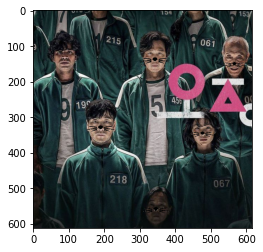

In [1293]:
plt.imshow(img_rgb)
plt.show()

for문을 적절히 사용하여 여러명의 수염을 붙히는 것도 성공했다! 왜 하필 알리만...
